### Install required libraries

In [136]:
!pip install -q gdown patool numpy pandas matplotlib torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [222]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import copy


import sys
from tqdm import tqdm

import gdown

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

%matplotlib inline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download training and validation data from Google Drive

In [2]:
file_id = "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
file = "Project_data.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", file)

Downloading...
From (original): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
From (redirected): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t&uuid=cd99e672-f7ec-43fb-89e8-b44161f705d7
To: /content/Project_data.zip
100%|██████████| 1.71G/1.71G [00:16<00:00, 102MB/s]


'Project_data.zip'

In [ ]:

# Remove extracted files if already exist
!rm -rf 'Project_data'
!unzip -qq file

In [190]:
data_root_dir = "/content/Project_data"
train_images_dir = os.path.join(data_root_dir, 'train')
val_images_dir = os.path.join(data_root_dir, 'val')
train_csv_file = os.path.join(data_root_dir, 'train.csv')
val_csv_file = os.path.join(data_root_dir, 'val.csv')

In [212]:
train_data_df = pd.read_csv(train_csv_file)
df = pd.DataFrame(train_data_df.iloc[:, 0].str.split(';').tolist(), columns = ['folder', 'label','class'])
classes = df['class'].unique()

In [75]:
# Hyperparameters
num_epochs = 10
batch_size = 1
learning_rate = 0.001

In [240]:
class CustomVideoDataset(Dataset):

  def __init__(self, images_dir, data_file, transform):

    self.images_dir = images_dir
    self.transform = transform
    data_df = pd.read_csv(data_file)
    self.data = data_df.iloc[:, 0].str.split(';')

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    images = []
    images_path = os.path.join(self.images_dir, self.data[index][0])
    print(f'Loading video images from folder {images_path}')
    for image_file in os.scandir(images_path):
      image = Image.open(os.path.join(images_path, image_file))
      if self.transform:
        image = self.transform(image)
      images.append(image)

    label = self.data[index][2]

    x = torch.stack(images)
    y = torch.tensor(int(label), dtype=torch.long)

    return x, y


In [241]:
transform = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = CustomVideoDataset(train_images_dir, train_csv_file, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

val_dataset = CustomVideoDataset(val_images_dir, val_csv_file, transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [242]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

In [233]:
print(len(train_loader), len(val_loader))

662 99


In [234]:
print(len(train_dataset), len(val_dataset))

662 99


In [117]:
def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

Loading video images from folder /content/Project_data/train/WIN_20180925_17_18_28_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_18_56_Pro_Left_Swipe_new


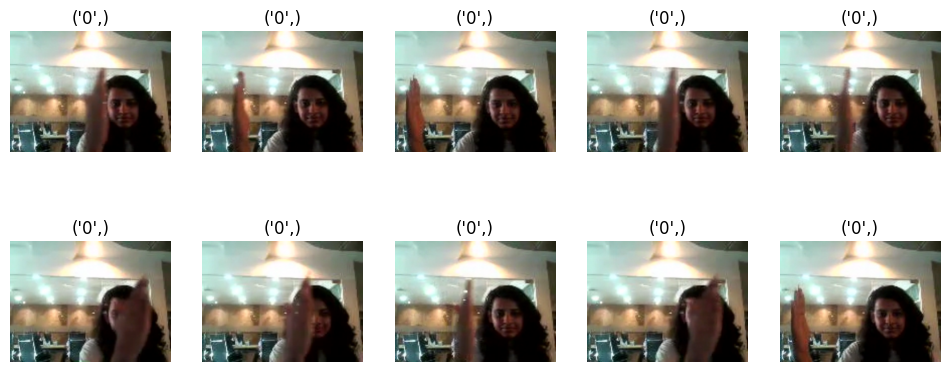

In [141]:
train_video_images, label = next(iter(train_loader))
_, axs = plt.subplots(2, 5, figsize=(12, 5))

index = 0
for row in range(2):
  for col in range(5):
    input_tensor= inverse_normalize(tensor=train_video_images[index])
    img = input_tensor.squeeze(0)
    axs[row, col].imshow(transforms.ToPILImage()(img))
    axs[row, col].set_title(label)
    axs[row, col].axis('off')
    index += 1

In [217]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [218]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
print(model.head)
model = model.to(device)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=5, bias=True)
)


In [219]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [220]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [243]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() # step at end of epoch

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [244]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/9
----------


  0%|          | 0/662 [00:00<?, ?it/s]

Loading video images from folder /content/Project_data/train/WIN_20180925_17_18_28_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_18_56_Pro_Left_Swipe_new


  0%|          | 0/662 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 4)